# 2.10 Reducción de la dimensionalidad

Lo ideal sería no tener que extraer o seleccionar características en los datos de entrada. Sin embargo, puede resultar ventajoso reducir la dimensionalidad como un paso de preprocesamiento independiente:

1. La complejidad del algoritmo depende del número de dimensiones de entrada y del tamaño de los datos.
2. Si algunas características son innecesarias, no extraerlas ahorra tiempo de cálculo
3. Los modelos más sencillos son más robustos en conjuntos de datos pequeños
4. Un menor número de características permite comprender mejor los datos.
5. La visualización es más fácil con menos dimensiones.



La *selección de características* encuentra las dimensiones que explican los datos sin pérdida de información y termina con una dimensionalidad menor de los datos de entrada. Un enfoque de *selección hacia delante* empieza con una variable que disminuye más el error y la añade una a una. Una *selección hacia atrás* empieza con todas las variables y las elimina una a una.

La *extracción de características* encuentra un nuevo conjunto de dimensiones como combinación de las dimensiones originales. Pueden ser supervisadas o no supervisadas dependiendo de la información de salida. Ejemplos: **Análisis de Componentes Principales**, **Análisis de Componentes Independientes** **Análisis Discriminante Lineal**.



## 1. Análisis de componentes principales

El PCA es un método de aprendizaje no supervisado que encuentra la correspondencia entre la entrada y un espacio de menor dimensión con una pérdida mínima de información. En primer lugar, descargaremos de nuevo nuestras series temporales de GPS de Oregón.

In [1]:
# Importar módulos útiles
import requests, zipfile, io, gzip, glob, os
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
import pandas as pd
import matplotlib
from matplotlib import cm
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn

## 2. Selección de características mediante exploración de parámetros

In [2]:
# Funciones de mapa de calor
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Crea un mapa de calor a partir de una matriz numpy y dos listas de etiquetas.

    Parámetros
    ----------
    datos
        Un array numpy 2D de forma (M, N).
    etiquetas_filas
        Una lista o matriz de longitud M con las etiquetas de las filas.
    etiquetas_columna
        Una lista o matriz de longitud N con las etiquetas de las columnas.
    ax
        Una instancia de `matplotlib.axes.Axes` en la que se traza el mapa térmico.  Si no se proporciona
        no se proporciona, utiliza los ejes actuales o crea uno nuevo.  Opcional.
    cbar_kw
        Un diccionario con argumentos para `matplotlib.Figure.colorbar`.  Opcional.
    cbarlabel
        La etiqueta para la barra de colores.  Opcional.
    **kwargs
        Todos los demás argumentos se envían a `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Graficar el mapa de calor
    im = ax.imshow(data, **kwargs)

    # Crear la barra de colores
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Mostrar todas las marcas y etiquetarlas con las entradas respectivas de la lista.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Permitir que las etiquetas de los ejes horizontales aparezcan en la parte superior.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotar las etiquetas de las marcas y establecer su alineación.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Desactivar las líneas de los ejes y crear una cuadrícula blanca.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    Una función para anotar un mapa de calor.

    Parámetros
    ----------
    im
        La AxesImage a etiquetar.
    Datos
        Datos utilizados para anotar.  Si es None, se usan los datos de la imagen.  Opcional.
    valfmt
        El formato de las anotaciones dentro del mapa de calor.  Debería
        utilizar el método de formato de cadena, por ejemplo, "$ {x:.2f}", o ser un
        `matplotlib.ticker.Formatter`.  Opcional.
    textcolors
        Un par de colores.  El primero se utiliza para los valores por debajo de un umbral,
        el segundo para los superiores.  Opcional.
    umbral
        Valor en unidades de datos según el cual se aplican los colores de textcolors.
        colores de textcolors.  Si es None (el valor por defecto) utiliza el centro del mapa de colores como
        separación.  Opcional.
    **Argumentos
        Todos los demás argumentos se envían a cada llamada a `text` utilizada para crear
        las etiquetas de texto.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalizar el umbral a la gama de colores de las imágenes.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Ajuste la alineación por defecto al centro, pero permita que sea
    # sobrescrito por textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Obtener el formateador en caso de que se proporcione una cadena
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Recorre los datos y crea un `Texto` para cada "pixel".
    # Cambia el color del texto dependiendo de los datos.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

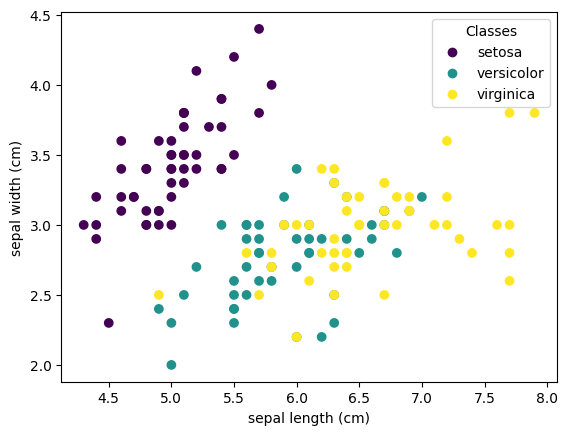

In [3]:
# Carguemos el conjunto de datos del iris
iris = datasets.load_iris()

# Convertir iris en un marco de datos pandas...
irisDF = pd.DataFrame(data=iris.data,  
                  columns=iris.feature_names)

# # Ahora, traza la longitud de los sépalos frente a la anchura, codificados por colores por objetivo (o especie)

scatter = plt.scatter(irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], c=iris.target)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")

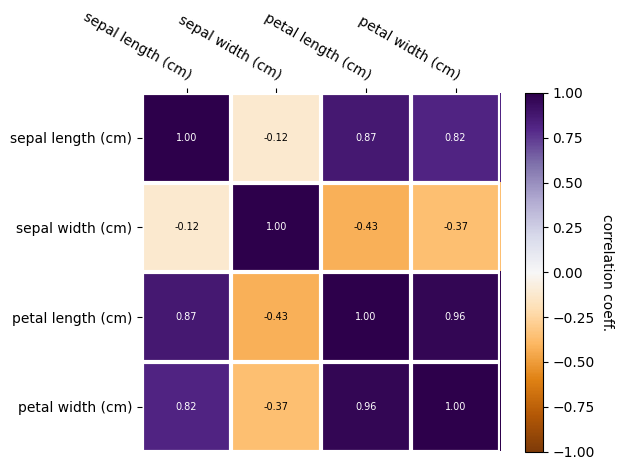

In [4]:
# Ahora, ¿cómo podríamos reducir estas dimensiones? 
# Una forma es observando cómo se correlacionan las variables.
# Calcular los coeficientes de correlación para todas las variables.
allCorr = irisDF.corr()

im, _ = heatmap(allCorr, irisDF.head(), irisDF.head(),
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

annotate_heatmap(im, size=7)

plt.tight_layout()
plt.show()

Ahora, ¿qué dimensiones podríamos eliminar?

## 3. Extracción de características mediante PCA

El análisis de componentes principales (**PCA**) identifica el eje que representa la mayor cantidad de varianza en los datos. 

Sea: $\mathbf{Y} = \mathbf{y}_1,\cdots,\mathbf{y}_n $ los datos, medidos $n$ veces sobre múltiples campos de medidas (la longitud de $\mathbf{y})$. 

Cada **columna** de $ \mathbf{y}_n $ representa una única observación. Cada **fila** de $ \mathbf{Y} $ representa un único parámetro.  

Para realizar el ACP

1. 1. Centrar y normalizar los datos restando la media de cada fila de $ \mathbf{Y} $.
2. 2. Calcular la matriz de covarianza de los datos de-meaned $\mathbf{C} = \frac{1}{n-1} \mathbf{Y}^{\ast}\mathbf{Y}$. Por definición, la matriz de covarianza es simétrica positiva y, por tanto, puede diagonalizarse.
3. Calcular el *Singular Value Decomposition (SVD)* de la matriz de covarianza $\mathbf{C} $. 

Como su nombre indica, la SVD descompone la matriz de covarianza de datos $\mathbf{C} $ en 3 términos:

$\mathbf{X} = \mathbf{U} \Sigma \mathbf{V}^T ,$

donde $\mathbf{V}^T$ contiene los vectores propios, o componentes principales. 

Los componentes principales están normalizados, centrados en cero.

El * 1er componente principal * eigenvector tiene el mayor valor propio en la dirección que tiene la mayor varianza.

Para demostrar la aplicación del PCA, empezaremos con unos datos de juguete: una nube de puntos bidimensional (2D) formada por 10.000 observaciones, cada una de ellas con dos parámetros.

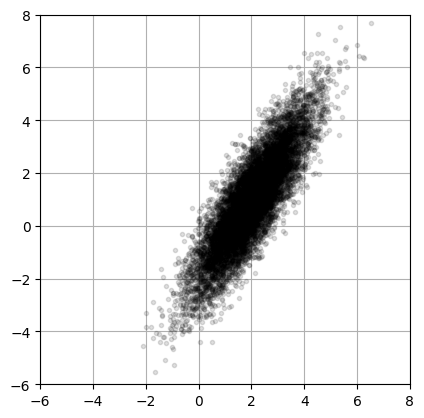

In [5]:
# Generando los datos de juguete
xC = np.array([2, 1])      # Centro de los datos (promedio)
sig = np.array([2, 0.5])   # Ejes principales
theta = np.pi/3            # Gira la nube en pi/3
R = np.array([[np.cos(theta), -np.sin(theta)],     # Matriz de rotación
              [np.sin(theta), np.cos(theta)]])
nPoints = 10000            # Crear 10,000 puntos

# # crear la nube de puntos multiplicando (np.matmul también es llamado por @)
X = R @ np.diag(sig) @ np.random.randn(2,nPoints) + np.diag(xC) @ np.ones((2,nPoints))
# plot the data
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)
ax1.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax1.set_aspect('equal')

### *Paso 1* :  restar el promedio

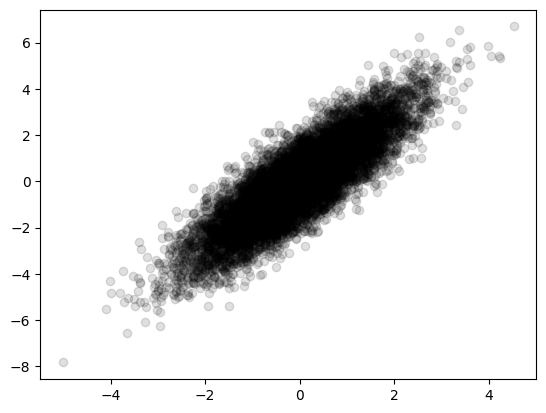

In [9]:
## Remover el promedio de los datos
Xavg = np.mean(X, axis=1)                 # Calcular el promedio
B = X - np.tile(Xavg,(nPoints,1)).T       # Promedio-restado de los datos

plt.scatter(B[0,:],B[1,:], color='k', alpha=0.125)

### *Paso 2*: Determinar el SVD de la matriz de covarianza

In [10]:
# Encontrar los componentes principales (SVD): 
# usar la opción full_matrices =0 calculará la covarianza de B
# Aquí, transponemos B para que cada observación esté en una fila

U, S, VT = np.linalg.svd(B.T,full_matrices=0)

### *Paso 3* : explorar los resultados

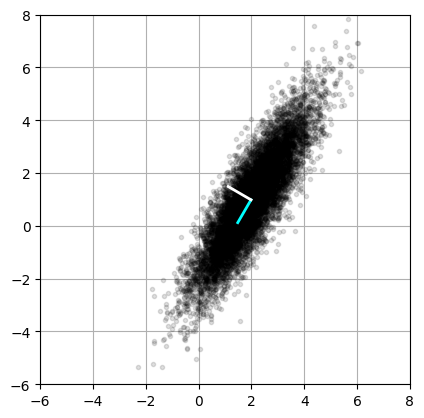

In [65]:

fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(X[0,:],X[1,:], '.', color='k', alpha=0.125)   # Graficar los datos para superponer PCA
ax2.grid()
plt.xlim((-6, 8))
plt.ylim((-6,8))
ax2.set_aspect('equal')

# Graficar los autovectores VT[:,0] and VT[:,1]
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,0]]),
         np.array([Xavg[1], Xavg[1]+VT[1,0]]),'-',color='cyan',linewidth=2)
ax2.plot(np.array([Xavg[0], Xavg[0]+VT[0,1]]),
         np.array([Xavg[1], Xavg[1]+VT[1,1]]),'-',color='white',linewidth=2)

plt.show()

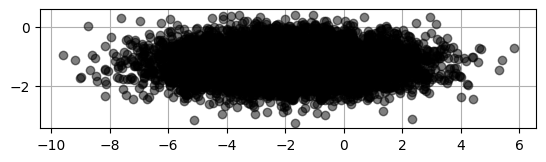

In [70]:
# Proyectemos los datos originales
# Proyectando los datos sobre los vectores singulares derechos

projected = X.T.dot(VT.T)

plt.scatter(projected[:,0], projected[:,1], c='k', alpha=0.5)
ax = plt.gca()
ax.set_axisbelow(True)
ax.grid()
ax.set_aspect('equal')


## 4. PCA en datos 3D.

Ahora vamos a trabajar sobre la componente 3D de los movimientos de superficie registrados en datos de GPS. 

Nuestros 3 parámetros son desplazamientos en: Este, Norte y Vertical. Estas mediciones se realizan diariamente durante muchos años.

In [11]:
# Descargar datos y guardar en un pandas.
sta="P395"
file_url="http://geodesy.unr.edu/gps_timeseries/tenv/IGS14/"+ sta + ".tenv"
r = requests.get(file_url).text.splitlines()  # descargar, leer texto, dividir líneas en una lista.
ue=[];un=[];uv=[];se=[];sn=[];sv=[];date=[];date_year=[];df=[]
for iday in r:  # este bucle a través de los días de datos
    crap=iday.split()
    if len(crap)<10:
      continue
    date.append((crap[1]))
    date_year.append(float(crap[2]))
    ue.append(float(crap[6])*1000)
    un.append(float(crap[7])*1000)
    uv.append(float(crap[8])*1000)
# Extraer las tres dimensiones de los datos
E = np.asarray(ue)# Componente Este
N = np.asarray(un)# Componente Norte
U = np.asarray(uv)# Componente Vertical

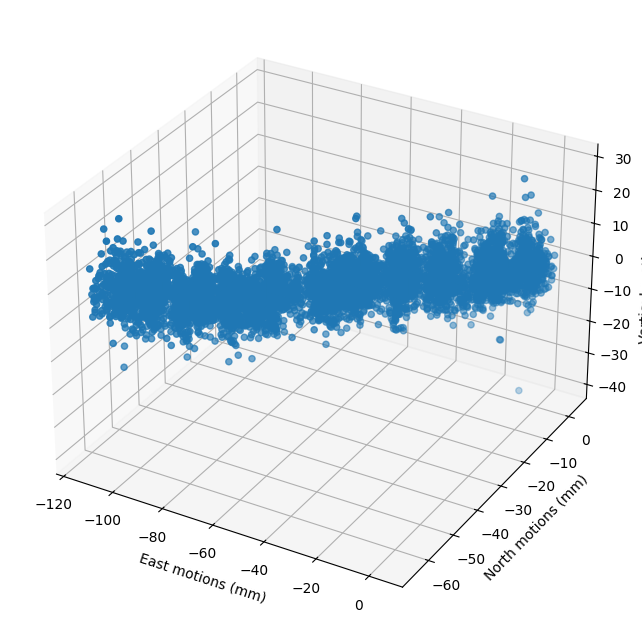

In [12]:
# graficar los datos
fig=plt.figure(figsize=(11,8))
ax=fig.add_subplot(projection='3d')
ax.scatter(E,N,U);ax.grid(True)
ax.set_xlabel('Movimientos del Este (mm)')
ax.set_ylabel('Movimientos del Norte(mm)')
ax.set_zlabel('Movimientos verticales (mm)')
plt.show()

In [13]:
# Vamos a organizar nuestros datos de GPS en una matriz
X = np.vstack([E,N,U])
print(U.shape)
print(X.shape)
nPoints=U.shape[0]
{
    "tags": [
        "hide-output"
    ]
}

(6341,)
(3, 6341)


{'tags': ['hide-output']}

In [14]:
## Remover el promedio de los datos
Xavg = np.mean(X,axis=1)                  # Calculo del promedio
B = X - np.tile(Xavg,(nPoints,1)).T       # promedio-substraido de los datos

In [2]:
# Encontrar componentes principales (SVD): 
# usar la opción full_matrices =0 calculará la covarianza de B
U, S, VT = np.linalg.svd(B.T/np.sqrt(nPoints),full_matrices=0)
print(S)
plt.plot(S);plt.grid(True)
plt.xticks(range(0,3));plt.title('Valores propios de los movimientos 3D');plt.show()

NameError: name 'B' is not defined

There are 3 components of motion, but the majority of the motion is explained in 1 direction.

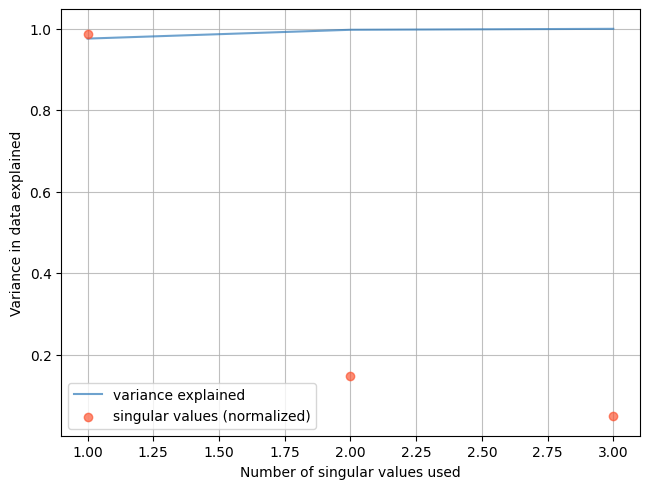

In [16]:
numSV = np.arange(1, S.size+1)

cumulativeVarianceExplained = [np.sum(np.square(S[0:n])) / np.sum(np.square(S)) for n in numSV]

plt.plot(numSV,
         cumulativeVarianceExplained,
         color='#2171b5',
         label='variance explained',
         alpha=0.65,
         zorder=1000)

plt.scatter(numSV,
            sklearn.preprocessing.normalize(S.reshape((1,-1))),
            color='#fc4e2a',
            label='valores singulares(normalizados)',
            alpha=0.65,
            zorder=1000)

plt.grid(alpha=0.8, zorder=1)
plt.tight_layout()
ax = plt.gca()
ax.set_xlabel(r'Número de valores singulares usados)
ax.set_ylabel('Varianza de los datos explicada')
plt.legend()

El primer vector propio que explica la mayor parte de la varianza está orientado en dirección Este.

Ahora vamos a utilizar el paquete ``sklearn``. El modelo ``PCA`` se encarga de la transformación de los datos (eliminar la media y estandarizar), calcular la covarianza, y el SVD.

**AVISO:** Numpy y sklean no organizan los datos en la misma dimensión. 
* Usando sklearn, organiza los datos para cada campo como una columna.
* Usando numpy, organiza los datos para cada campo como una fila.

In [17]:
from sklearn.decomposition import PCA # este es el modelo SKEAN 
pca=PCA(n_components=3).fit(X.transpose())# conservar los 3 componentes
print(pca)

PCA(n_components=3)


In [18]:
# Los 3 PCs
print(pca.components_)

[[-0.88070032 -0.47256154  0.03244272]
 [-0.0475276   0.02001436 -0.99866939]
 [-0.47128343  0.88107038  0.04008636]]


In [19]:
# Los 3 PCs' varianza explicada
print(pca.explained_variance_)

[1362.43901058   30.20454172    3.29046581]


Ahora se ve que la mayor parte de la varianza se explica por la primera PC. ¿Qué acimut es la dirección de la primera PC?

In [20]:
import math
azimuth=math.degrees(math.atan2(pca.components_[0][0],pca.components_[0][1]))
if azimuth <0:azimuth+=360
print("direction of the plate ",azimuth," degrees from North")

direction of the plate  241.7831169485096  degrees from North


[0.97600531 0.02163751 0.00235718]


Text(0.5, 1.0, 'Cumulative PCs')

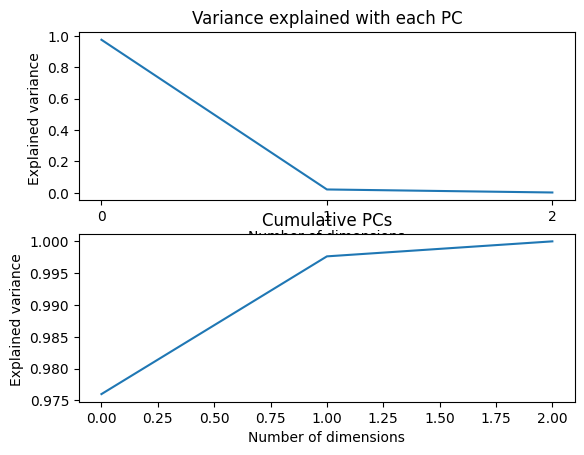

In [21]:
# Proporción de varianza explicada de las 3 PC: qué parte de la varianza explica cada componente.
print(pca.explained_variance_ratio_)
fig,ax=plt.subplots(2,1)
ax[0].plot(pca.explained_variance_ratio_);ax[0].set_xticks(range(0,3))
ax[0].set_xlabel('Número de dimensiones')
ax[0].set_ylabel('Varianza explicada ')
ax[0].set_title('Varianza explicada con cada PC')
ax[1].plot(np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Número de dimensiones')
ax[1].set_ylabel('Varianza explicada')
ax[1].set_title('PC acumulados')

Ahora vemos que el 97% de la varianza la explica el primer PC. Podemos reducir la dimensión de nuestro sistema trabajando con una sola dimensión. Otra forma de elegir el número de dimensiones es seleccionar el mínimo de PC que expliquen el 95% de la varianza.

In [22]:
d = np.argmax(np.cumsum(pca.explained_variance_ratio_)>=0.95) +1
print("Tamaño mínimo de la dimensión para explicar el 95% de la varianza: ",d)

Minimum dimension size to explain 95% of the variance:  1


In [23]:
pca = PCA(n_components=d).fit(X)
X_pca = pca.transform(X)
print("forma original:   ", X.shape)
print("forma transformada:", X_pca.shape)

original shape:    (3, 6341)
transformed shape: (3, 1)


Transformación inversa de vuelta a los datos originales, pero sólo con el primer PC

(3, 6341)


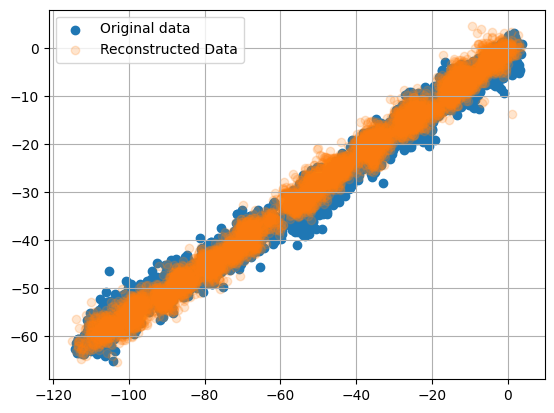

In [24]:
# Encontrar el acimut del vector desplazamiento
X_new = pca.inverse_transform(X_pca)
print(X_new.shape)
plt.scatter(X[0,:], X[1,:], alpha=1)
plt.scatter(X_new[0,:], X_new[1,:], alpha=0.2)
plt.legend(['Datos originales','Datos reconstruidos'])
plt.grid(True)
plt.show()

*SVD* puede ser intensivo desde el punto de vista computacional para dimensiones mayores.

Se recomienda utilizar un **PCA aleatorio** para aproximar los primeros componentes principales. Scikit-learn cambia automáticamente a PCA aleatorio en cualquiera de los siguientes casos: tamaño de los datos > 500, el número de vectores es > 500 y el número de PCs seleccionados es inferior al 80% de cualquiera de ellos.


## 5. Análisis de componentes independientes

El ICA se utiliza para estimar fuentes a partir de mediciones ruidosas. Se utiliza con frecuencia en geodesia para aislar las contribuciones de los terremotos y la hidrología.

In [3]:
from scipy import signal
from sklearn.decomposition import FastICA

#  Generar los datos de muestreo
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# crear 3 señales fuente
s1 = np.sin(2 * time)  # Señal 1 : señal sinousoidal
s2 = np.sign(np.sin(3 * time))  # Señal 2 : señal cuadrada
s3 = signal.sawtooth(2 * np.pi * time)  # Señal 3: señal de diente de sierra


S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Añadir ruido
S /= S.std(axis=0)  # Estandarizar los datos

print(S)



[[ 0.495126    0.07841108 -1.31840023]
 [ 0.64019598  1.34570272 -1.94657351]
 [ 0.28913069  0.9500949  -1.646886  ]
 ...
 [-0.38561943 -0.71624672  1.34043406]
 [-0.50777458 -1.24052539  1.74176784]
 [-0.5550078  -0.90265774 -1.54534953]]


In [4]:
# Mezclar datos
# Crear 3 señales en 3 receptores:
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]) # Matriz de mezcla
X = np.dot(S, A.T) # Generar observaciones
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X) # Reconstruir señales
A_ = ica.mixing_ # Obtención de la matriz de mezcla estimada
print(A_,A)
# Por comparación, calcule PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X) # Reconstruye las señales basadasn en las componentes ortogonales


[[-46.02147955  42.50809743  45.32804372]
 [-44.05919471  21.19031463  88.65606826]
 [-91.72748329  61.75542772  44.5776646 ]] [[1.  1.  1. ]
 [0.5 2.  1. ]
 [1.5 1.  2. ]]


In [ ]:
plt.figure(figsize=(11,8))
models = [X, S, S_, H]
names = ['Observaciones (señal mixta)',
         'Fuentes verdaderas',
         'Señales recuperadas ICA', 
         'Señales recuperadas PCA']
colors = ['red', 'steelblue', 'orange']
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)
plt.tight_layout()
plt.show()

## 6. Otras técnicas


1. Proyecciones aleatorias
https://scikit-learn.org/stable/modules/random_projection.html
2. Escalado multidimensional
3. Isomapa
4. Incrustación estocástica de vecinos distribuida en t
5. Análisis discriminante lineal